In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%load_ext autoreload

In [2]:
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers,models,utils

import matplotlib.pyplot as plt

In [21]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [12]:
def build_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(input_dim,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [7]:
print('x_train shape : %s' % str(x_train.shape))
print('y_train shape : %s' % str(y_train.shape))
print('x_test shape : %s' % str(x_test.shape))
print('y_test shape : %s' % str(y_test.shape))

x_train shape : (404, 13)
y_train shape : (404,)
x_test shape : (102, 13)
y_test shape : (102,)


In [8]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std
x_test -= mean
x_test /= std

In [13]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([x_train[:i * num_val_samples],x_train[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples],y_train[(i + 1) * num_val_samples:]],axis=0)
    model = build_model(partial_train_data.shape[1])
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


In [14]:
all_scores

[2.5605118, 2.3314772, 2.830965, 2.4235432]

In [15]:
np.mean(all_scores)

2.5366242

In [16]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i+1)
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([x_train[:i * num_val_samples],x_train[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples],y_train[(i + 1) * num_val_samples:]],axis=0)
    model = build_model(partial_train_data.shape[1])
    history = model.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [18]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

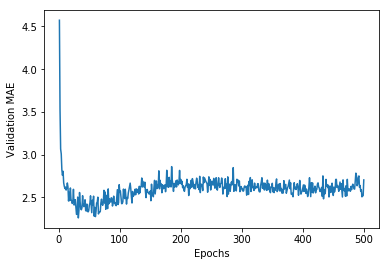

In [19]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

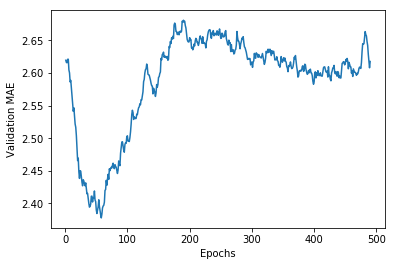

In [22]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [23]:
model = build_model(x_train.shape[1])
model.fit(x_train, y_train, epochs=80, batch_size=16)

Epoch 1/80
404/404 [==============================] - 0s 429us/sample - loss: 480.6283 - mean_absolute_error: 19.9990
Epoch 2/80
404/404 [==============================] - 0s 159us/sample - loss: 303.3222 - mean_absolute_error: 15.1748
Epoch 3/80
404/404 [==============================] - 0s 174us/sample - loss: 134.3651 - mean_absolute_error: 9.3217
Epoch 4/80
404/404 [==============================] - 0s 187us/sample - loss: 56.22

In [24]:
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

102/102 [==============================] - 0s 581us/sample - loss: 20.0241 - mean_absolute_error: 2.7138
